# 4_ReviseCareAI_Reports
## The purpose of that notebook: to visualize insights

In [1]:
pip install ipywidgets

StatementMeta(, 61691626-eb23-4276-851d-4530860b79b5, 5, Finished, Available, Finished)

Note: you may need to restart the kernel to use updated packages.


In [2]:
%run 0_ReviseCareAI_Utils

StatementMeta(, 61691626-eb23-4276-851d-4530860b79b5, 14, Finished, Available, Finished)

Variables GMAP_API_KEY, OPENAI_API_KEY, AZURE_OPEN_AI_KEY, AZURE_OPEN_AI_ENDPOINT were initialized
Google client gmaps was is initialized
Function list_to_dataframe() is initialized
Function get_ids_from_config() is initialized
Function get_hospital_details() is initialized
Function openai_get_answer() is initialized
UDF Function openai_udf() is initialized
Function string_masking() is initialized
UDF Function string_masking_udf() is initialized


# Data Insights

In [3]:
enriched_genai = spark.read.format("delta").load("Files/enriched_genai")
display(enriched_genai)
enriched_genai.cache()
enriched_genai.createOrReplaceTempView("genai_view")

StatementMeta(, 61691626-eb23-4276-851d-4530860b79b5, 15, Finished, Available, Finished)

SynapseWidget(Synapse.DataFrame, 4787fa2d-a526-411a-8e53-39adc44a03e5)

In [4]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def getListValuesFromDF(df, col):
    return df.select(col).distinct().orderBy(col).rdd.flatMap(lambda x: x).collect()

def getSimpleCharBar(query, x_label, y_label, title, color='blue'):
    import matplotlib.pyplot as plt
    import pandas as pd

    pdf = spark.sql(query).toPandas()

    # Plotting the bar chart using Matplotlib
    plt.figure(figsize=(10, 6))
    plt.bar(pdf['category'], pdf['metric'], color=color)

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=45, ha='right')

    # Show the plot
    plt.tight_layout()
    plt.show()


def getGroupedBarChart(query, group_col, category_col, metric_col, x_label, y_label, title, group_legend = 'group', colors=None):
    # Fetch the data from Spark SQL query and convert it to a pandas DataFrame
    pdf = spark.sql(query).toPandas()

    # Get unique categories (x-axis) and groups (different bars for each category)
    categories = pdf[category_col].unique()
    groups = pdf[group_col].unique()

    # If colors are not provided, generate a list of colors from the colormap
    if colors is None:
        cmap = plt.colormaps.get_cmap('tab10')  # Get the colormap
        colors = [cmap(i) for i in range(len(groups))]  # Generate distinct colors for each group

    # Define the width of each bar
    bar_width = 0.2

    # Define the x-axis positions for the categories
    indices = np.arange(len(categories))

    # Create a figure
    plt.figure(figsize=(12, 6))

    # Loop through each group and plot its bars
    for i, group in enumerate(groups):
        # Filter the dataframe for the current group
        group_data = pdf[pdf[group_col] == group]

        # Ensure the data is sorted by category to match x-axis positions
        group_data = group_data.set_index(category_col).reindex(categories).reset_index()

        # Plot the bars for this group
        plt.bar(indices + i * bar_width, group_data[metric_col], width=bar_width, label=group, color=colors[i])

    # Add labels and title
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)

    # Add category labels with adjusted tick positions for grouped bars
    plt.xticks(indices + bar_width * (len(groups) - 1) / 2, categories, rotation=45, ha='right')

    # Add a legend
    plt.legend(title=group_legend)

    # Show the plot
    plt.tight_layout()
    plt.show()

def GetTrendReviews(hospital):
    import matplotlib.pyplot as plt
    import pandas as pd
    import matplotlib.dates as mdates

    # Assuming you have your Spark DataFrame 'df_spark' with columns 'date', 'positive', 'negative'

    # Convert Spark DataFrame to Pandas DataFrame
    df = spark.sql(f'''
        with cte as (
            select 
                date_format(review_time, 'yyyy-MM') as date
                ,case when UPPER(sentiment) like '%POSITIVE%' THEN 1 ELSE 0 END as positive
                ,case when UPPER(sentiment) like '%NEGATIVE%' THEN 1 ELSE 0 END as negative
            from
                genai_view
            where hospital_name = '{hospital}'
        )
        select
            date, sum(positive) as positive, sum(negative) as negative
        from cte
        group by date
        order by date
    ''')

    df_pandas = df.toPandas()

    # Ensure 'date' column is treated as datetime for better plotting
    # df_pandas['date'] = pd.to_datetime(df_pandas['date'])

    # Plotting
    plt.figure(figsize=(10, 6))
    plt.plot(df_pandas['date'], df_pandas['positive'], label='Positive', color='green', marker='o')
    plt.plot(df_pandas['date'], df_pandas['negative'], label='Negative', color='red', marker='x')

    # Add labels and title
    plt.xlabel('Date')
    plt.ylabel('Metrics')
    plt.title(f'Positive vs Negative Metrics Over Time - {hospital}')

    # Add grid and legend
    plt.grid(True)
    plt.legend()

    # Show the plot
    plt.xticks(rotation=45)  # Rotate x-axis labels if needed
    plt.tight_layout()  # Adjust layout to prevent label cutoff
    plt.show()

StatementMeta(, 61691626-eb23-4276-851d-4530860b79b5, 16, Finished, Available, Finished)

StatementMeta(, 61691626-eb23-4276-851d-4530860b79b5, 17, Finished, Available, Finished)

Dropdown(description='Hospital:', options=('Masked:Alqlus Akluxdqsr Jqrkxsdq - Adj Gxlwq', 'Masked:Aunxkkr Iln…

Dropdown(description='Hospital to compare:', index=1, options=('Masked:Alqlus Akluxdqsr Jqrkxsdq - Adj Gxlwq',…

Button(description='Show Report', icon='check', style=ButtonStyle(), tooltip='Click to submit')

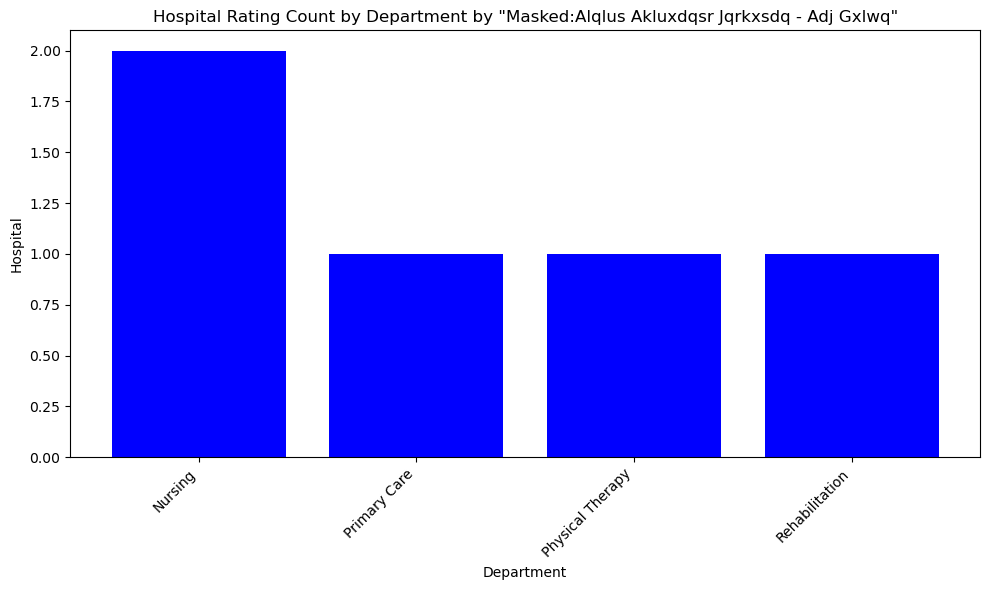

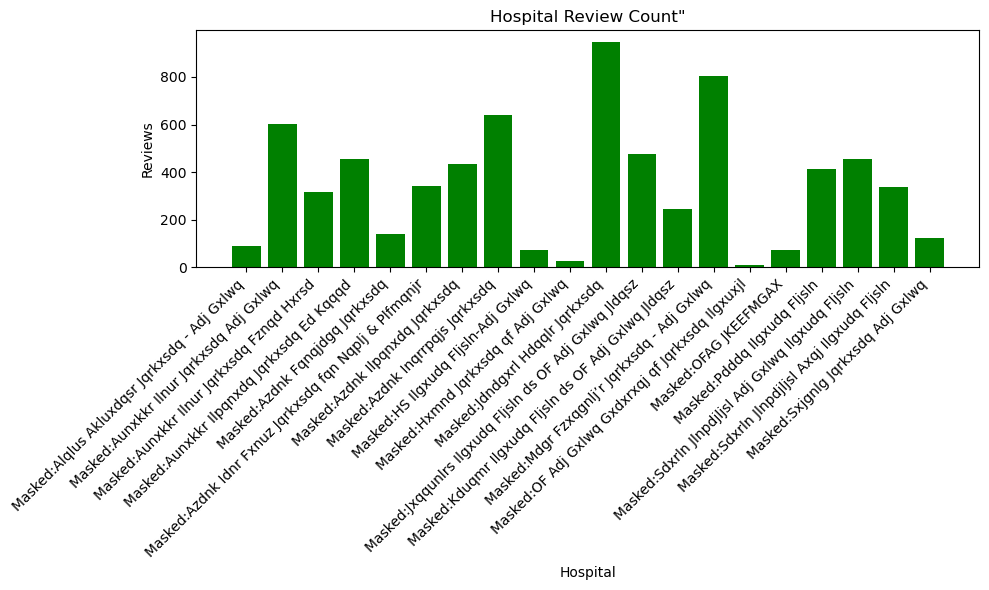

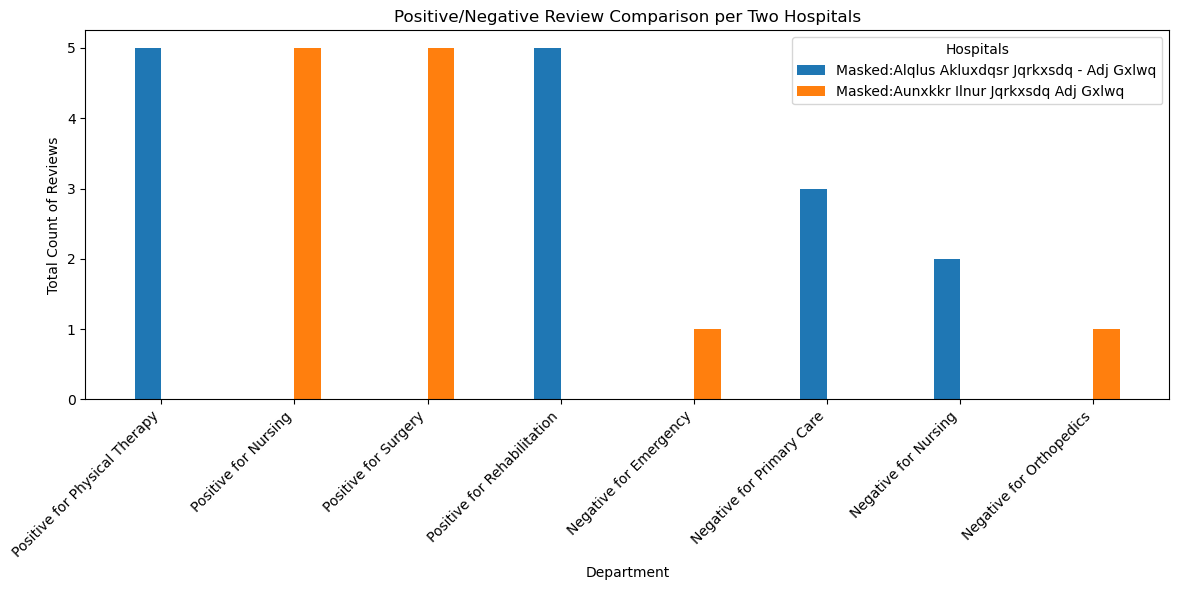

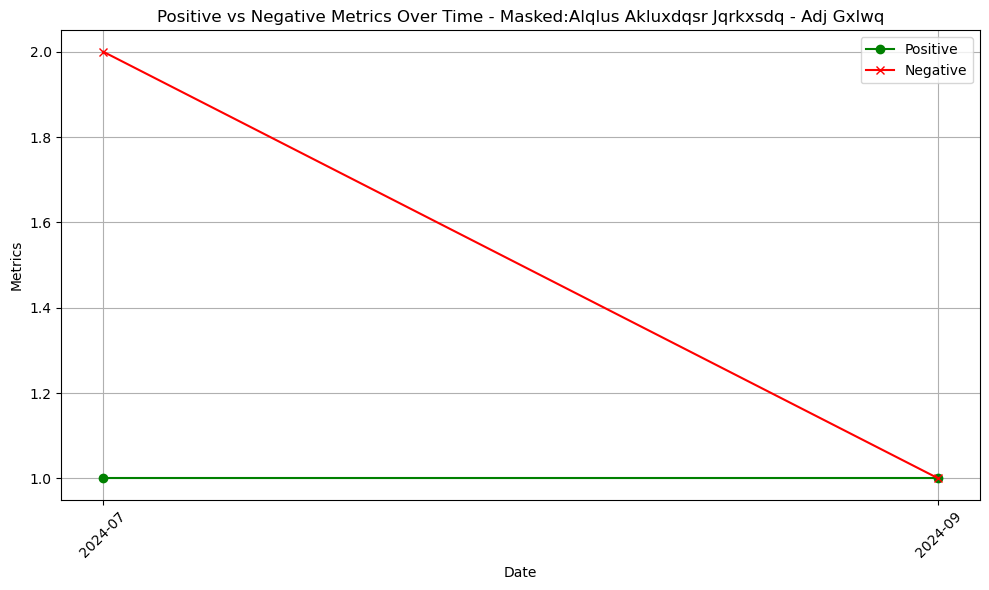

StatementMeta(, 61691626-eb23-4276-851d-4530860b79b5, 18, Finished, Available, Finished)

In [5]:
hospital_dropdown = widgets.Dropdown(
    options=getListValuesFromDF(df=enriched_genai, col='hospital_name'),
    value=getListValuesFromDF(df=enriched_genai, col='hospital_name')[0],
    description='Hospital:',
)

hospital_dropdown2 = widgets.Dropdown(
    options=getListValuesFromDF(df=enriched_genai, col='hospital_name'),
    value=getListValuesFromDF(df=enriched_genai, col='hospital_name')[1],
    description='Hospital to compare:',
)

submit_button = widgets.Button(
    description='Show Report',
    button_style='',
    tooltip='Click to submit',
    icon='check'
)



def buildReports():
    getSimpleCharBar(
        query=f'''
            select department as category, count(*) as metric
            from genai_view
            where hospital_name='{hospital_dropdown.value}'
            group by department
            ''', 
        x_label='Department', 
        y_label='Hospital', 
        title=f'Hospital Rating Count by Department by "{hospital_dropdown.value}"')

    getSimpleCharBar(
        query=f'''
            select 
                hospital_name as category
                ,max(hospital_rating_cnt) as metric
            from genai_view
            group by hospital_name
            order by hospital_name
            ''', 
        x_label='Hospital', 
        y_label='Reviews', 
        title=f'Hospital Review Count"',
        color='green'
    )

    getGroupedBarChart(
        query=f'''select 
                    hospital_name as group
                    ,CONCAT('Positive for ', department) as category
                    ,avg(review_rating) as metric
                from genai_view
                where 
                    hospital_name in ('{hospital_dropdown.value}', '{hospital_dropdown2.value}')
                    and UPPER(sentiment) like '%POSITIVE%'
                group by hospital_name, department
                
                UNION ALL
                
                select 
                    hospital_name as group
                    ,CONCAT('Negative for ', department) as category
                    ,avg(review_rating) as metric
                from genai_view
                where 
                    hospital_name in ('{hospital_dropdown.value}', '{hospital_dropdown2.value}')
                    and UPPER(sentiment) like '%NEGATIVE%'
                group by hospital_name, department            
                ''',
        group_col="group",  # Example group column
        category_col="category",  # Example category column
        metric_col="metric",  # Example metric column
        x_label="Department",
        y_label="Total Count of Reviews",
        group_legend='Hospitals',
        title="Positive/Negative Review Comparison per Two Hospitals",
    )

    GetTrendReviews(hospital=hospital_dropdown.value)

    ####



def on_submit_button_clicked(b):
    clear_output(wait=True)
    display(hospital_dropdown, hospital_dropdown2, submit_button)
    buildReports()

submit_button.on_click(on_submit_button_clicked)
display(hospital_dropdown, hospital_dropdown2, submit_button)

buildReports()